In [17]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import pandas as pd
import folium

## 1. Read data

In [14]:
# should take about 30 sec to read
hyads_df1 = pd.read_csv("./model_dev_data/hyads_coal_part1.csv", index_col=0)
hyads_df2 = pd.read_csv("./model_dev_data/hyads_coal_part1.csv", index_col=0)
hyads_df3 = pd.read_csv("./model_dev_data/hyads_coal_part1.csv", index_col=0)
hyads_df = pd.concat([hyads_df1, hyads_df2, hyads_df3], 1)
del hyads_df1, hyads_df2, hyads_df3
hyads = hyads_df.values  # as numpy
hyads_df.iloc[:10,:10]

,10001,10002,10003,10004,10005,10006,10007,10008,10009,1001
fid,,,,,,,,,,
10,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.5
1001,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,39.0,29.5
1004,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,25.5
10043,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,107.0,24.5
10071,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,14.5
10075,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,34.5
1008,33.5,33.5,33.5,33.5,33.5,33.5,33.5,33.5,33.5,34.5
1010,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,34.0
10111,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,49.5


In [63]:
hyads_mini_df = pd.read_csv("./model_dev_data/hyads_zipcode_3digits.csv", index_col=0)
hyads_mini = hyads_mini.values

In [8]:
# hyads1 = hyads_df.iloc[:,:15000]
# hyads1.to_csv("./model_dev_data/hyads_coal_part1.csv")
# hyads2 = hyads_df.iloc[:,15001:30000]
# hyads2.to_csv("./model_dev_data/hyads_coal_part2.csv")
# hyads3 = hyads_df.iloc[:,30001:-1]
# hyads3.to_csv("./model_dev_data/hyads_coal_part3.csv")

In [20]:
# rows are power plants
# index is fid (power plant id)
# columns zip codes
hyads_df.shape

(444, 45000)

In [18]:
power_plants = pd.read_csv("./model_dev_data/power_plant_info.csv", index_col=0)
power_plants = power_plants[power_plants.index.isin(hyads_df.index)]
power_plants.shape

(444, 2)

In [19]:
power_plants.head()

,lat,lon
fid,,
3,31.0069,-88.0103
7,34.0128,-85.9708
8,33.6446,-87.2003
10,32.6017,-87.7811
26,33.2442,-86.4567


In [21]:
my_USA_map = './model_dev_data/us-states.json'

In [22]:
fig = folium.Figure(width=630, height=400)
m = folium.Map(location=[39, -96],
               zoom_start=4, 
               zoom_control=False)
for i in range(power_plants.shape[0]):
    loc = power_plants.iloc[i]
    folium.CircleMarker(
        location=loc,
        radius=1.5,
        color="red",
        opacity=0.5
    ).add_to(m)
fig.add_child(m)
m

## 2. Mixture Model

For now, let's fix the number of components

In [65]:
n_comps = 3
n_plants = hyads.shape[0]
# n_zip_samples = 45000
# samples = np.random.choice(hyads.shape[1], size=n_zip_samples)
# hyads0 = hyads[:, samples]
hyads0 = hyads_mini

In [67]:
gmm = GaussianMixture(
    n_components=n_comps,
    covariance_type="full")
gmm.fit(hyads0)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [68]:
phat = gmm.predict_proba(hyads0)
gmm.converged_

True

In [69]:
colorpal = sns.color_palette("husl", n_comps).as_hex()

In [70]:

labels = np.zeros(n_plants, int)
for i in range(n_plants):
    labels[i] = np.random.choice(n_comps, p=phat[i])
print("Num labels: ", len(np.unique(labels)))
    
fig = folium.Figure(width=630, height=400)
m = folium.Map(location=[39, -96],
               zoom_start=4, 
               zoom_control=False)

comps_to_plot = range(n_comps)
# comps_to_plot = []
for c in comps_to_plot:
    for i in range(n_plants):
        loc = power_plants.iloc[i]
        lab = labels[i]
        if lab == c:
            folium.CircleMarker(
                location=loc,
                radius=5.0,
                color=colorpal[labels[i]],
                stroke=False,
                fill=True,
                fill_opacity=0.9
            ).add_to(m)
m.add_to(fig)

Num labels:  3


In [71]:
cov = gmm.covariances_
cov.shape

(3, 866, 866)

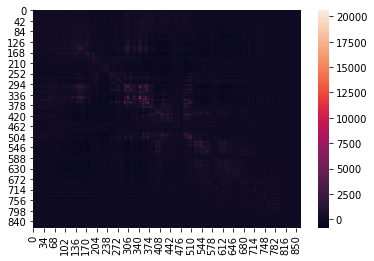

In [72]:
sns.heatmap(cov[0])

(array([116., 199., 249., 172.,  87.,  31.,   6.,   4.,   0.,   2.]),
 array([4.37200638e-02, 1.26196323e+01, 2.51955445e+01, 3.77714567e+01,
        5.03473689e+01, 6.29232811e+01, 7.54991933e+01, 8.80751055e+01,
        1.00651018e+02, 1.13226930e+02, 1.25802842e+02]),
 <a list of 10 Patch objects>)

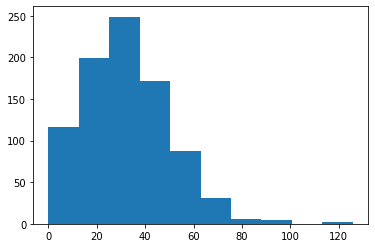

In [73]:
plt.hist(hyads_mini.std(0))